# Setup

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
!pip install scikit-learn
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Defaulting to user installation because normal site-packages is not writeable


# Get Data

## Download Data

In [4]:
!pip install pandas
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data() 

Defaulting to user installation because normal site-packages is not writeable


## Quick look at Data Structure

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
# save figures as high-res PNGs

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

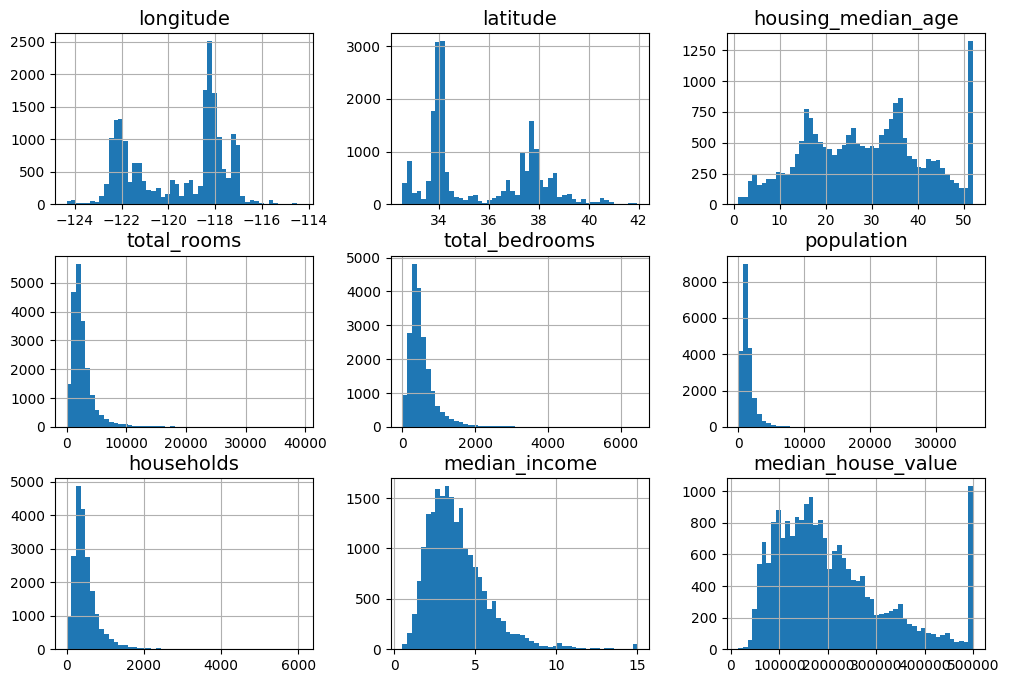

In [11]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

# Create Test Set

In [12]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [14]:
len(test_set)

4128

In [15]:
np.random.seed(42)

In [16]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * (2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Using row index as identifying column...

In [17]:
housing_with_id = housing.reset_index() # adds an "index" column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

Using latitude and longitude values to make a new identifying column

In [18]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Using scikit-learn to make the train-test split

In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [20]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [21]:
# showing how to campute the 10.7% probability of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
prob_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
prob_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(prob_too_small + prob_too_large)

0.10736798530929942


In [22]:
# another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

In [23]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

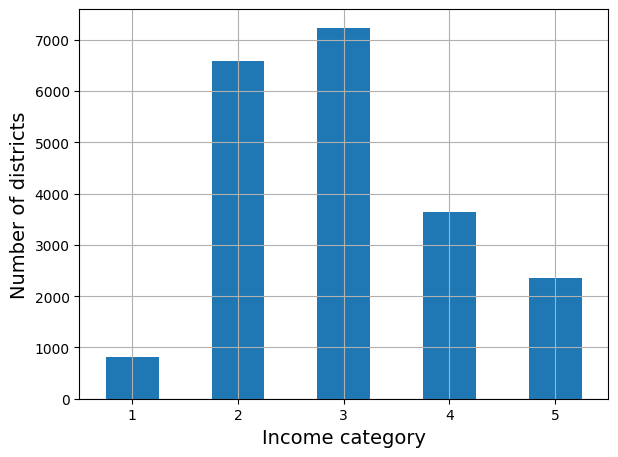

In [24]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

Generate 10 different stratified splits of the same dataset

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

Just use the first split for now.

In [26]:
strat_train_set, strat_test_set = strat_splits[0]

In [27]:
len(strat_train_set)

16512

It's much shorter to get a single stratified split:

In [28]:
strat_train_set, strat_test_set = train_test_split(
    housing,
    test_size=0.2,
    stratify=housing["income_cat"],
    random_state=42
)

In [29]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error%"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props * 100).round(2)



,Overall %,Stratified %,Random %,Strat. Error%,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [32]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [34]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

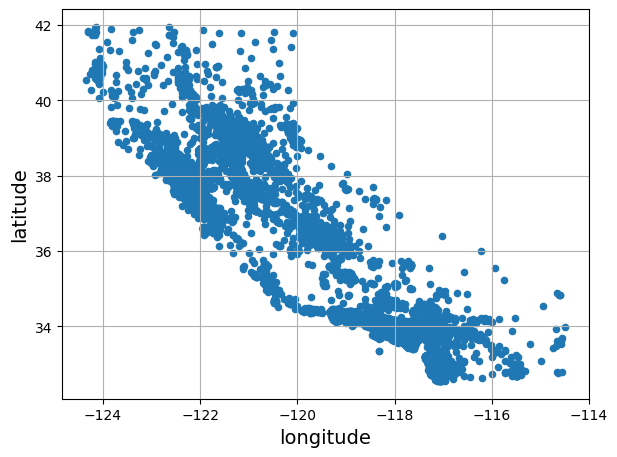

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

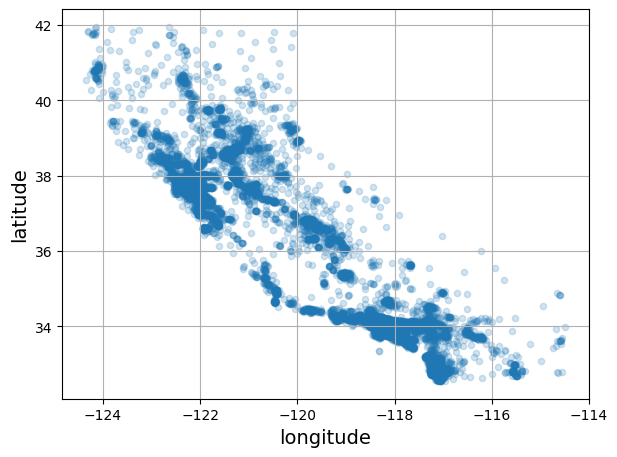

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

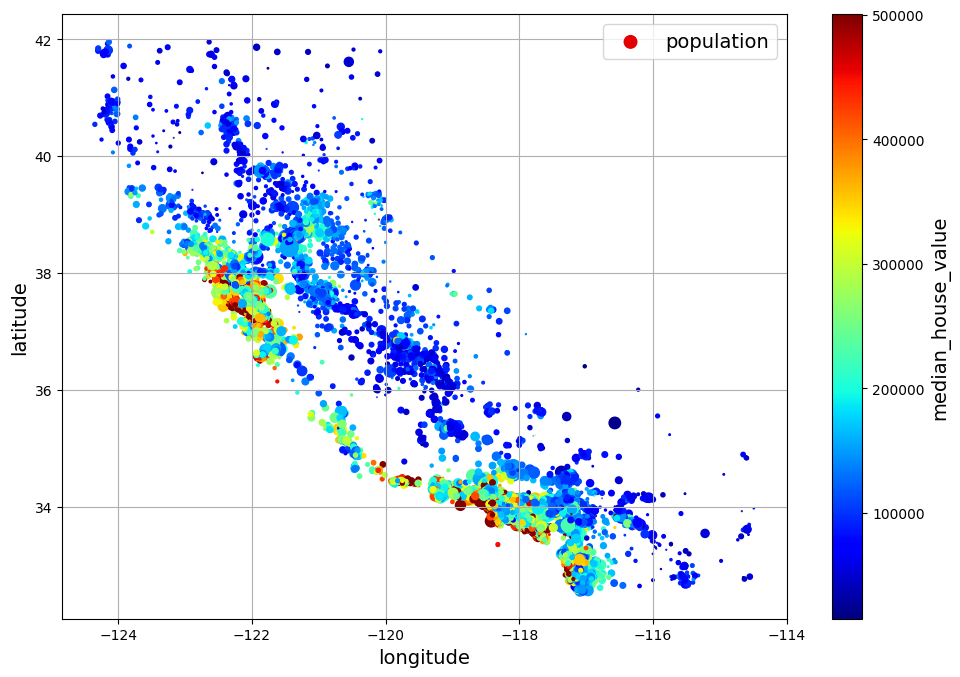

In [37]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    s=housing["population"] / 100,
    label="population",
    c="median_house_value",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7)
)
save_fig("housing_prices_scatterplot")
plt.show()

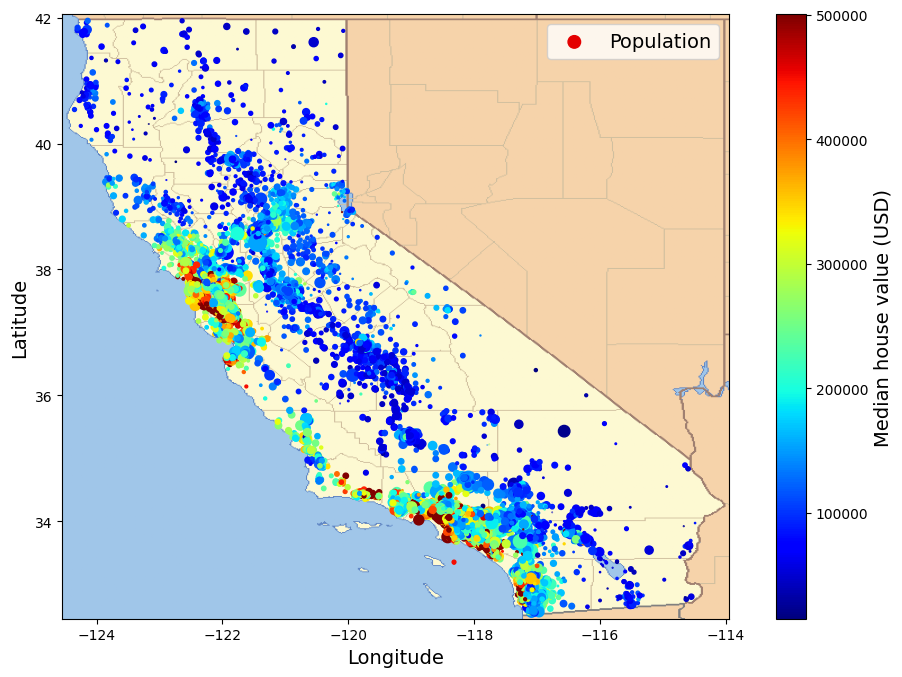

In [39]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH /filename)

housing_renamed = housing.rename(
    columns={
        "latitude": "Latitude",
        "longitude": "Longitude",
        "population": "Population",
        "median_house_value": "Median house value (USD)"
    }
)
housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Median house value (USD)",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7)
)
california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations

In [40]:
corr_matrix = housing.corr(numeric_only=True)

In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

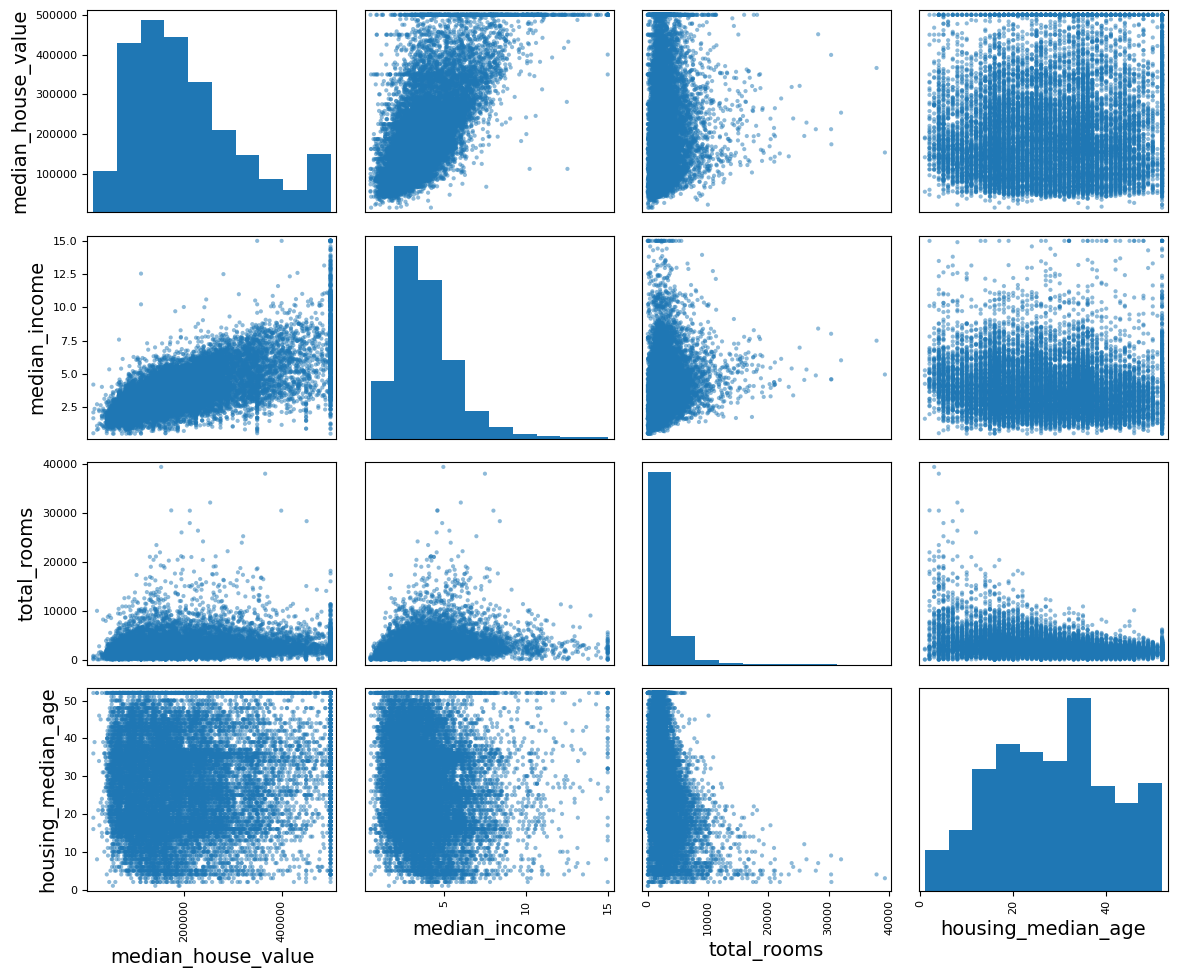

In [44]:
from pandas.plotting import scatter_matrix

attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age"
]
scatter_matrix(housing[attributes], figsize=(12, 10))
save_fig("scatter_matrix_plot")
plt.show()

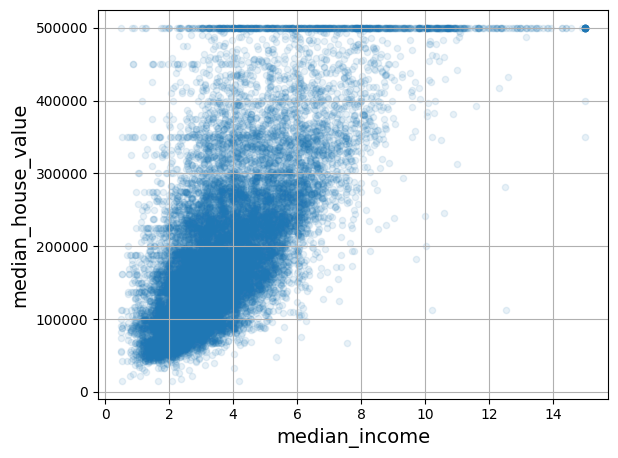

In [45]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")
plt.show()         